#Feedforward Neural Network with Graph Neural Network (GNN) Visualization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from skimage.segmentation import slic
import networkx as nx

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5366502.45it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159422.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272187.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7398263.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
import torch.nn.functional as F

#Define the Graph Neural Network model
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model and train it
gnn_model = GNNModel()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [4]:
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=5):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                test_loss = criterion(outputs, labels)
                running_test_loss += test_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = running_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies

train_losses_gnn, train_accuracies_gnn, test_losses_gnn, test_accuracies_gnn = train_model(gnn_model, optimizer, criterion, train_loader, test_loader, epochs=5)



Epoch 1/5, Train Loss: 0.3518, Train Accuracy: 90.38%, Test Loss: 0.2025, Test Accuracy: 94.02%
Epoch 2/5, Train Loss: 0.1674, Train Accuracy: 95.11%, Test Loss: 0.1306, Test Accuracy: 96.24%
Epoch 3/5, Train Loss: 0.1139, Train Accuracy: 96.69%, Test Loss: 0.1062, Test Accuracy: 96.83%
Epoch 4/5, Train Loss: 0.0854, Train Accuracy: 97.53%, Test Loss: 0.0882, Test Accuracy: 97.47%
Epoch 5/5, Train Loss: 0.0667, Train Accuracy: 97.98%, Test Loss: 0.0835, Test Accuracy: 97.38%


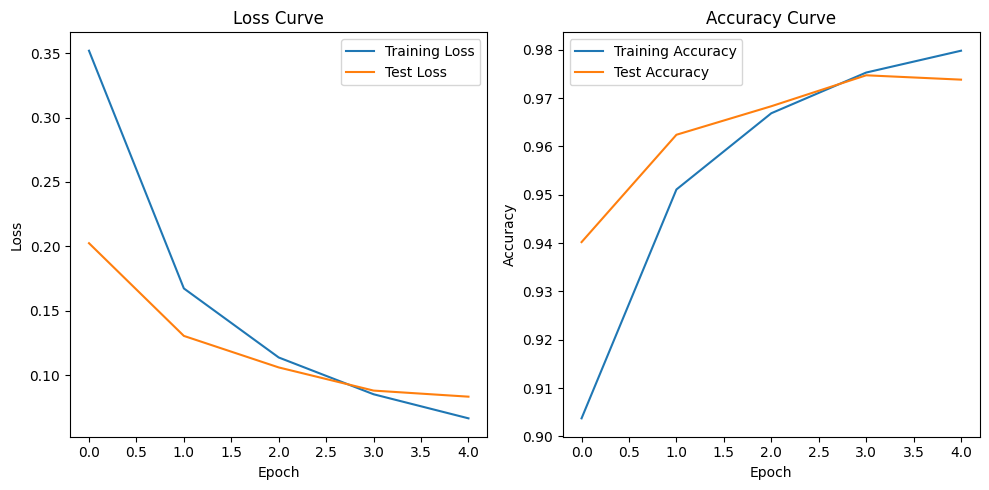

In [5]:
# Plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gnn, label='Training Loss')
plt.plot(test_losses_gnn, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_gnn, label='Training Accuracy')
plt.plot(test_accuracies_gnn, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

In [6]:

def visualize_connectivity(image, predicted_digit, group_size=2, background_color='lightblue'):
    # Rotate the image clockwise by 90 degrees
    image_rotated = torch.rot90(image, k=-1, dims=(1, 2))

    # Convert the rotated image to numpy array
    image_np = image_rotated.squeeze().numpy()

    # Group pixels
    def group_pixels(image, group_size):
        height, width = image.shape
        grouped_image = np.zeros((height // group_size, width // group_size))
        for i in range(0, height, group_size):
            for j in range(0, width, group_size):
                grouped_image[i // group_size, j // group_size] = np.mean(image[i:i+group_size, j:j+group_size])
        return grouped_image

    grouped_image = group_pixels(image_np, group_size)

    # Create a graph using NetworkX
    G = nx.Graph()

    # Identify the pixels forming the digit
    digit_pixels = np.argwhere(grouped_image > 0)

    # Add nodes for digit pixels
    for pixel in digit_pixels:
        G.add_node(tuple(pixel))

    # Add edges for adjacent digit pixels
    for pixel in digit_pixels:
        x, y = pixel
        if x + 1 < grouped_image.shape[0] and (x + 1, y) in digit_pixels:
            G.add_edge(tuple(pixel), (x + 1, y))
        if y + 1 < grouped_image.shape[1] and (x, y + 1) in digit_pixels:
            G.add_edge(tuple(pixel), (x, y + 1))

    # Plot the graph with border around nodes and background color fill
    pos = {node: node for node in G.nodes()}
    plt.figure(figsize=(4, 4))  # Set the overall figure size
    ax = plt.gca()
    ax.set_facecolor(background_color)

    # Draw a rectangle to fill the background
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=background_color, zorder=-1, transform=ax.transAxes))

    nx.draw(G, pos, node_color='b', with_labels=False, node_size=10, edge_color='k', ax=ax)  # Add edge_color parameter for border
    plt.title(f'Connectivity Plot - Predicted Digit: {predicted_digit}')

    # Add numbering to x and y axes
    plt.xticks(np.arange(0, grouped_image.shape[1] + 1, 1))
    plt.yticks(np.arange(0, grouped_image.shape[0] + 1, 1))

    plt.show()



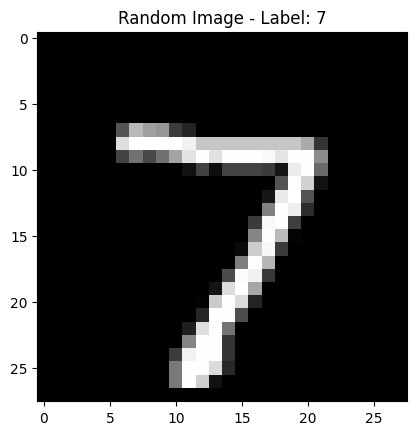

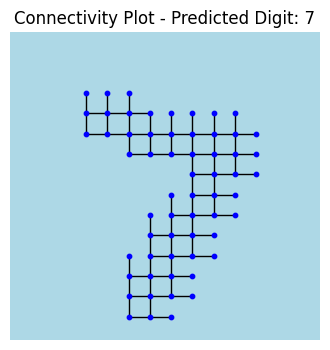

In [7]:
# Choose a random image from the test dataset
random_batch = next(iter(test_loader))
random_image, random_label = random_batch[0][0], random_batch[1][0]

# Get the predicted digit using the trained GNN model
with torch.no_grad():
    output = gnn_model(random_image.unsqueeze(0))
predicted_digit = torch.argmax(output, dim=1).item()

# Display the random image
plt.imshow(random_image.squeeze().numpy(), cmap='gray')
plt.title(f'Random Image - Label: {random_label.item()}')
plt.show()

# Visualize the connectivity  using the trained GNN model
visualize_connectivity(random_image, predicted_digit, group_size=2)
